In [1]:
import re
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr 
from scipy import interpolate
import matplotlib.pyplot as plt 

import thermal.plotting as plotting
from thermal.open import __preprocess
from thermal.plotting import enthalpy_pcolormesh
from thermal.derived_fields import (calc_mean_enthalpy, 
                                    calc_length)


plt.rcParams['text.usetex'] = True

In [2]:
key = 'crmpt12'

Let's find of a list of the simulations which reached some time threshold. 

This is mainly to filter out runs that failed (mostly likely to CFL condition problems). 

In [3]:
file_list = []

i = 0 
j = 0 

# src_dir = '/Volumes/thermal_ssd/crmpt12/thinned/'
src_dir = '/Volumes/thermal/thermal-structure/expr/00_CoupledInit/result/crmpt12/thinned/'
files = [os.path.join(src_dir, f) for f in os.listdir(src_dir) if re.search(r'^crmpt12.*((-0.[2-4][0-9])|-0.50).*.zarr$', f)]


# for file in files:
for file in glob.glob(src_dir + '*.zarr'):
    i += 1    
    with xr.open_zarr(file) as src: 
        if src.t[-1] >= 2000: 
            file_list.append(file) 
            j += 1
            
    
# filtered = [f for f in files if not (('-8.5' in f) & ('-0.31' in f or '-0.36' in f or '-0.27' in f))]

In [4]:
rate = (j / i) * 100

print(f'{rate:.0f} % success rate')

100 % success rate


In [5]:
%%time

SS_2kya = xr.open_mfdataset(file_list, engine='zarr', parallel=False)

# actually make the relative volume relatives
SS_2kya['relative_volume'] /= SS_2kya['relative_volume'].isel(t=0)

CPU times: user 8.51 s, sys: 663 ms, total: 9.17 s
Wall time: 9.58 s


In [6]:
H_mean = SS_2kya['height'].isel(coord_2=-1,t=-1).where(lambda x: x!=0).mean('coord_1')

In [7]:
SS_2kya['relative_volume'].to_netcdf('crmpt12_dx50_nz15_relative_volume.nc')
SS_2kya[['Z','X']].isel(coord_2=[0,-1], t=slice(0,None,10)).compute().to_netcdf('crmpt12_dx50_nz15_Z.nc')

In [8]:
%%time 

subset = SS_2kya[['enthalpy_h', 'height', 'X', 'Z']].isel(t=slice(-10,None)).compute()
# use the last year's worth of data to compute the weighted mean enthalpy in kJ / kg
mean_enthalpy = calc_mean_enthalpy(subset) / 1e3
# calculte annual average and mask the zero's as nans
mean_enthalpy = mean_enthalpy.mean('t').where(lambda x: x!=0, np.nan)

CPU times: user 38 s, sys: 24.3 s, total: 1min 2s
Wall time: 6min 11s


In [9]:
%%time 
# using the subset of data we need, stack N the parameter dims along a single new dimension "param"
stacked = subset.isel(t=-1).stack(param = ('T_ma', 'offset'))
# apply the "calc_length" function over the "param" dimension, 
# then unstack the results to return to original N parameter dims
length  = stacked.groupby('param').apply(calc_length).unstack()

# now get the water content along the base of the glacier
basal_ω = SS_2kya['water content'].isel(t=-1, coord_2=0).persist()
# now calculte the fractional length using basal water content
temp_L  = xr.where(basal_ω > 0.001, 50/1e3, 0.0).sum('coord_1')
# need to deal with nan's, i.e. where the temperate length is zero
temp_L = xr.where(temp_L==0, np.nan, temp_L)

CPU times: user 17.7 s, sys: 7.64 s, total: 25.4 s
Wall time: 1min 52s


In [10]:
def interpolate_na_2D(ds): 
    
    # collapse along a single dimension
    stacked = ds.stack(interper = ('offset', 'T_ma'))
    # drop the values which are nan
    thinned = stacked.where(~stacked.isnull(), drop=True)
    
    # create the radial basis function interpolator 
    def create_interpolater(X_obs, Y_obs, Z_obs):
        data_coords = np.vstack([X_obs, Y_obs]).T
        return interpolate.RBFInterpolator(data_coords, Z_obs)
    
    # create an instance of the the interpolator 
    interpolater = create_interpolater(thinned.offset, 
                                       thinned.T_ma,
                                       thinned)
    
    def evaluate(X,Y): 
        Z = interpolater(np.vstack([X, Y]).T)
        return Z
    
    return xr.apply_ufunc(evaluate,
                   stacked.offset,
                   stacked.T_ma,
                   input_core_dims=[["interper"], ["interper"]],
                   output_core_dims=[["interper"]],
                   vectorize=True,
                   dask="parallelized",
                   output_dtypes=[stacked.dtype]).unstack()



In [11]:
def interpolate_grids(src, vars=['relative_volume', 'percent_temperate'], dims=['T_ma', 'offset']): 
    # make copy, new reference in memory 
    ds = src[vars].persist().copy()
    
    def fill_nans_1D(src, dim, method='cubic'): 
        
        # allow for extrapolation at boundaries
        kwargs = {"fill_value" : "extrapolate"}
        # interpolate over nans along a single dimension
        src = src.chunk({dim : -1}).interpolate_na(dim=dim, method=method, **kwargs)
        
        return src
    
    
    for var in vars: 
        ds[var] = interpolate_na_2D(ds[var])
    
    return ds

In [12]:
# get the boolean mask of nan values
mask  = np.isnan(SS_2kya.relative_volume.sel(t=2000, method='nearest').compute().values)
mask2 = np.isnan(SS_2kya.percent_temperate.sel(t=2000, method='nearest').compute().values)

assert np.alltrue(mask == mask2)

In [13]:
# start by interpolating nan's in the V' and % temp fields
interpolated = interpolate_grids(SS_2kya.isel(t=-1), 
                                 vars=['relative_volume', 'percent_temperate']).expand_dims('t')

interpolated['mask']  = xr.DataArray(mask[None,:,:], interpolated.coords)
interpolated['length'] = interpolate_na_2D(length).expand_dims('t')
interpolated['length'] = interpolate_na_2D(length).expand_dims('t')
interpolated['temp_length'] = interpolate_na_2D(temp_L).expand_dims('t')
interpolated['mean_enthalpy'] = interpolate_na_2D(mean_enthalpy).expand_dims('t')


In [14]:
interpolated.to_netcdf('crmpt12_dx50_nz15_SS_fields_@3ka.nc')

In [15]:
print(float(interpolated['mean_enthalpy'].min()))
print(float(interpolated['percent_temperate'].max()), float(interpolated['percent_temperate'].min()))

132.03997773104194
62.35825004497691 44.32082530643259


In [16]:
# Modeled grid of parameter vals
T_mgrid, B_mgrid = np.meshgrid(SS_2kya.T_ma, SS_2kya.offset)

# Dense grid of parameter vals for visulaization
T_dgrid, B_dgrid = np.meshgrid(np.linspace(T_mgrid.min(),T_mgrid.max(),50), 
                               np.linspace(B_mgrid.min(),B_mgrid.max(),50))



In [17]:
print(B_mgrid[:,:].shape)
print(T_mgrid[:,:].shape)
print(SS_2kya['percent_temperate'].shape)

(26, 11)
(26, 11)
(26, 11, 3000)


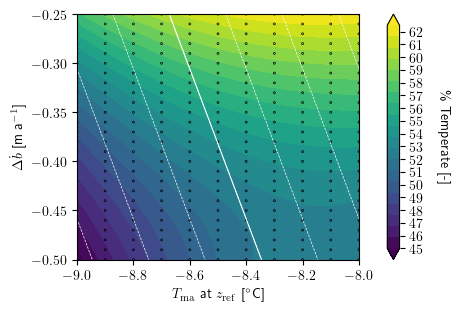

In [38]:

# greate spline fit parameters
tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['percent_temperate'].isel(t=-1).values)

znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)


fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)

if key == 'crmpt12': 
    levels = np.linspace(45,62.5, 21)
    
elif key == 'glc1-a': 
    levels = np.linspace(10, 45, 36)
    
    
im = ax.contourf(T_dgrid, B_dgrid, znew, levels=levels, extend='both')
# im = ax.scatter(T_mgrid, B_mgrid, c=SS_2kya.percent_temperate,  )
s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')
plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)


# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]') 
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')

if key == 'glc1-a': 
    ax.set_xlim(-8.0, None)

cbar = fig.colorbar(im, ticks=np.linspace(45, 62, 18), drawedges=False)
# annotate the colorbar axes
cbar.set_label('\% Temperate [-]', rotation=270, labelpad=20)

fig.savefig(f'./figs/{key}/{key}_PercTemp_GS_new.png',  dpi=600, bbox_inches='tight', facecolor='w')

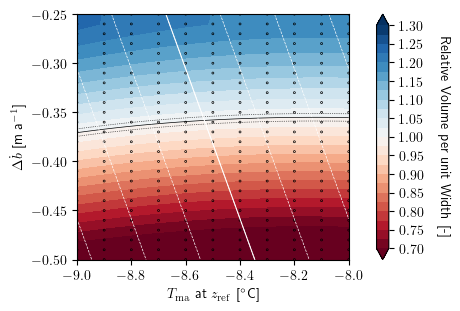

In [19]:
if key == 'crmpt12': 
    tck  = interpolate.bisplrep(B_mgrid[:-1,:], T_mgrid[:-1,:], interpolated['relative_volume'].isel(t=-1).values[:-1,:])
else: 
    tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['relative_volume'].isel(t=-1).values)
    
    
znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)

fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)


if key == 'crmpt12': 
    levels = np.linspace(40, 60, 21)
    
elif key == 'glc1-a': 
    levels = np.linspace(0, 45, 46)
    
im = ax.contourf(T_dgrid, B_dgrid, znew, levels=np.linspace(0.7,1.3,25), cmap='RdBu', extend='both')
# im = ax.scatter(T_mgrid, B_mgrid, c=SS_2kya.relative_volume,  cmap='RdBu',)

s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)


ax.contour(T_dgrid, B_dgrid, znew, levels=[0.99, 1.0, 1.01], linestyles=[':', '-', ':'], colors='k', linewidths=0.5)
# ax.contourf(T_dgrid, B_dgrid, znew, levels=[0.99, 1.01], cmap='binary', alpha=0.25)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')

plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)

# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]')
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')


cbar = fig.colorbar(im, ticks=np.linspace(0.7,1.3, 13), drawedges=False, extend='both')
# annotate the colorbar axes
cbar.set_label('Relative Volume per unit Width [-]', rotation=270, labelpad=20)



if key == 'glc1-a': 
    ax.set_xlim(-8.0, None)
    

fig.savefig(f'./figs/{key}/{key}_RelVol_GS_new.png', 
            dpi=600, bbox_inches='tight', 
            facecolor='w')

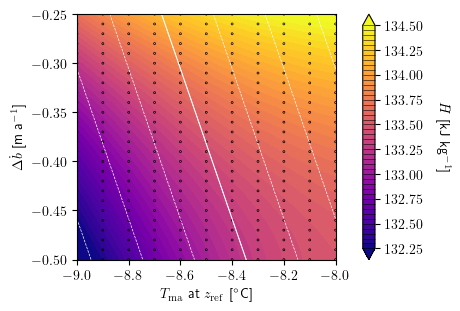

In [57]:
# # greate spline fit parameters
tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['mean_enthalpy'].isel(t=-1).values)

znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)


fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)

levels = np.linspace(132.25, 134.5, 46)
    

im = ax.contourf(T_dgrid, B_dgrid, znew, levels=levels, extend='both', cmap='plasma')
# im = ax.scatter(T_mgrid, B_mgrid, c=SS_2kya.per6cent_temperate,  )
s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')
plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)


# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]')
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')

if key == 'glc1-a': 
    ax.set_xlim(-8.0, None)

cbar = fig.colorbar(im, drawedges=True)
# annotate the colorbar axes
cbar.set_label(r'$\bar{H}$ [kJ kg$^{-1}$]', rotation=270, labelpad=20)
#
fig.savefig(f'./figs/{key}/{key}_MeanEnth_GS_new.png',  dpi=600, bbox_inches='tight', facecolor='w')

In [21]:
test = SS_2kya[['height', 'X']].isel(t=-1).compute()

In [22]:
if test.isel(offset=0, T_ma=0).height.isnull().all(): 
    print('ahhh shit')

`calc_length` is not designed to deal with high dimensional data. Instead it's meant to only deal with data with `dims`: 
  - `coord_1`
  - `coord_2`
  - `t` or `time`

Therefore we need to apply the `calc_length` function to each parameter combination seperately. To do this we first subset the variables we need (`height` and `X`), and collapse the two parameter dimensions (`T_ma` and `offset`) alng 

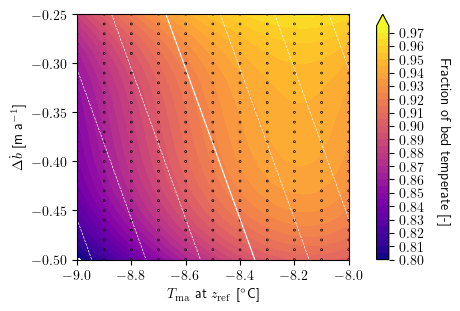

In [81]:
# # greate spline fit parameters
tck  = interpolate.bisplrep(B_mgrid, T_mgrid, (interpolated['temp_length'] / interpolated['length']).isel(t=-1))
znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)


fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)

levels = np.linspace(0.8, 0.975, 36)
    

im = ax.contourf(T_dgrid, B_dgrid, znew, levels=levels, extend='max', cmap='plasma')
s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')
plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)

# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]')
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')


cbar = fig.colorbar(im, ticks=levels[::2], drawedges=False)
# annotate the colorbar axes
cbar.set_label('Fraction of bed temperate [-]', rotation=270, labelpad=20)

# fig.savefig("../

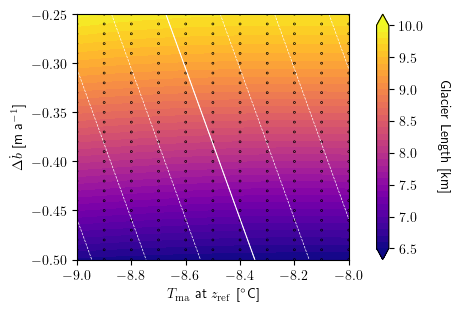

In [25]:
tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['length'].isel(t=-1))
znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)


fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)

levels = np.linspace(6.5, 10, 36)
    

im = ax.contourf(T_dgrid, B_dgrid, znew, levels=levels, extend='both', cmap='plasma')
s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')
plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)

# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]')
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')

cbar = fig.colorbar(im, ticks=levels[::5], drawedges=False, extend='both')
# annotate the colorbar axes
cbar.set_label('Glacier Length [km]', rotation=270, labelpad=20)

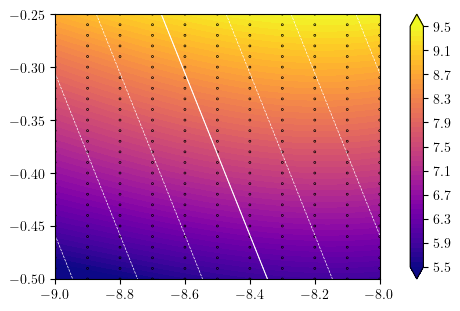

In [79]:
tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['temp_length'].isel(t=-1))
znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)


fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)

levels = np.linspace(5.5, 9.5, 51)
    

im = ax.contourf(T_dgrid, B_dgrid, znew, levels=levels, extend='both', cmap='plasma')
s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')
plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)

cbar = fig.colorbar(im, ticks=levels[::5], drawedges=False, extend='both')


In [27]:
if key == 'crmpt12': 
    subset = SS_2kya.isel(t=[0,-1], T_ma=[0, 5, 10], offset=[2 ,12,-4])
    # squeeze the subset.Xtime dimension, since 
    if 't' in subset.X.dims: 
        subset['X'] = subset.X.isel(t=0)
    
    L_subset = length.isel(T_ma=[0, 5, 10], offset=[2 ,12,-4])
elif key == 'glc1-a': 
    subset = SS_2kya.isel(T_ma=slice(10,None,2), offset=slice(0,None,4))
    

In [28]:
# refine the vertical resolution for plotting purposes
subset = subset.interp(coord_2=np.linspace(0,15,101))

2
1
0


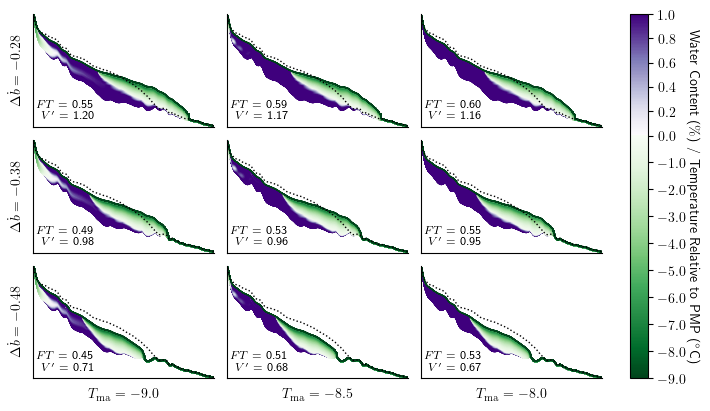

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(7, 4), 
                         sharex=True, sharey=True, 
                         constrained_layout=True)

for i in range(3): 
    
    k = 2-i
    print(2-i)
#     δ_b = float(subset.offset[i])
#     axes[i,  0].set_ylabel(f'$\Delta \dot{{b}}={δ_b}$')

#     if i > 0: 
#         j = i-1 
#         T_ma = float(subset.T_ma[j])
#         axes[-1, j].set_xlabel(f'$T_{{ma}} ={T_ma}$')
    
    for j in range(3):
        
        if j == 0: 
            δ_b = float(subset.offset[k])
            axes[i,  j].set_ylabel(f'$\Delta \dot{{b}}={δ_b}$')

        if i == 0: 
            # j = i-1 
            T_ma = float(subset.T_ma[j])
            axes[-1, j].set_xlabel(f'$T_{{\\rm ma}} ={T_ma}$')
            
            
        if pd.isna(subset.isel(T_ma=j, offset=k).enthalpy_h.mean()): 
            continue 
        
        im = enthalpy_pcolormesh(subset.isel(T_ma=j, offset=k), -1, 
                                 axes=axes[i,j], W_max=1.0, T_min=-9.0, 
                                 rasterized=True)
        
        # plot the inital condition
        axes[i,j].plot(subset.isel(T_ma=j, offset=k).X[0,::-1]/1e3, 
                       subset.isel(T_ma=j, offset=k).Z.isel(t=0, coord_2=-1),
                lw=1.0, c='k', ls=":", zorder=3, label='$z_{\\rm s}(t=0)$')    
        
        V = float(subset['relative_volume'].isel(t=-1, T_ma=j, offset=k))
        P = float(subset['percent_temperate'].isel(t=-1, T_ma=j, offset=k))
        
        axes[i,j].text(0.19, 0.1, f"$V'$ = {V:3.2f}", 
                           transform=axes[i,j].transAxes,
                           ha='center', va='center', fontsize='small')
        
        
        axes[i,j].text(0.175, 0.2, f"$FT$ = {P/100:0.2f}", 
                           transform=axes[i,j].transAxes,
                           ha='center', va='center', fontsize='small')
        
        axes[i,j].get_xaxis().set_ticks([])
        axes[i,j].get_yaxis().set_ticks([])
        
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)
            
        # axes[i,j].axvline(L_subset.isel(T_ma=j, offset=k))
        
        # for spine in axes[i, j].spines.values():
        #     spine.set_visible(False)

cbar = fig.colorbar(im, ax=axes) 
cbar.set_ticks(np.concatenate((np.linspace(-9, 0, 10),
               np.linspace(0.2, 1.0, 5))))
cbar.set_label('Water Content ($\%$) / Temperature Relative to PMP ($^\circ$C)', 
               rotation=270, labelpad=10)

# axes[0,0].set_xlim(None, 6e3)
# axes[0,0].set_ylim(1.75e3, None)

In [30]:
fig.savefig(f'./figs/{key}/{key}_distributed_GS_new.png', dpi=400)

In [31]:
sub = SS_2kya['relative_volume'].compute()

In [32]:
import matplotlib.cm as cm

def make_colorbar(array, cmap='plasma'):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    vmin  = array.min()
    vmax  = array.max()
    vsize = array.size
    vdv   = array[1] - array[0]
    
    cmap = getattr(cm, cmap)
    norm = cm.colors.Normalize(vmin=vmin, vmax=vmax)

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(np.linspace(vmin, vmax, vsize))

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = vdv / 2.0
    bounds   = np.linspace(vmin  - halfdist,
                           vmax  + halfdist,
                           vsize + 1)

    return cmap, norm, s_map, bounds

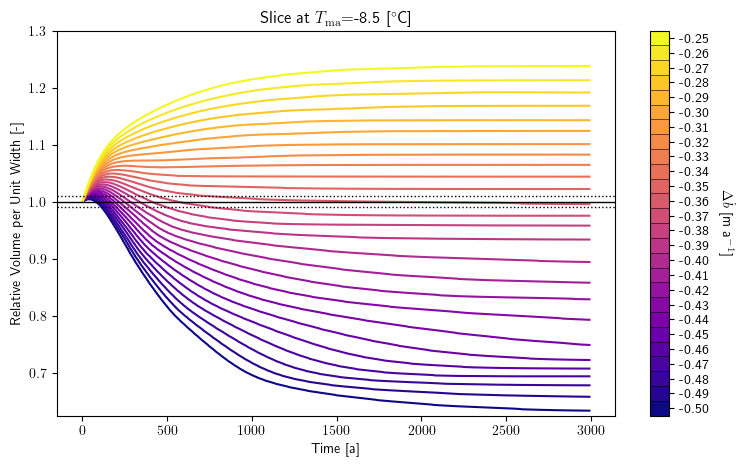

In [33]:
cmap, norm, s_map, bounds = make_colorbar(sub.offset)

fig, ax = plt.subplots(figsize=(9, 5))

for δb in sub.offset: 
    
    color = cmap(norm(δb))
    
    sub.sel(T_ma=-8.5, offset=δb).plot(x='t', ax=ax, c=color)

ax.axhline(0.99, ls=':', c='k', lw=1.0)
ax.axhline(1.01, ls=':', c='k', lw=1.0)
ax.axhline(1.00, ls='-', c='k', lw=1.0)


cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=np.linspace(sub.offset.min(),
                                  sub.offset.max(),
                                  sub.offset.size),
                ax=ax,
                boundaries=bounds,
                drawedges=True,
                format='%2.{}f'.format(2))

ax.set_title(r'Slice at $T_{\rm ma}$=-8.5 [$^\circ$C]')
ax.set_ylabel('Relative Volume per Unit Width [-]')
ax.set_xlabel('Time [a]')
# annotate the colorbar axes
cbar.set_label('$\Delta \dot b$ [m a$^{-1}$]', rotation=270, labelpad=20)

ax.set_ylim(0.625, 1.30)


fig.savefig(f'./figs/{key}/{key}_Vprime_wrt_offset_at_Tma_-8.5.png', 
            dpi=600, bbox_inches='tight', 
            facecolor='w')

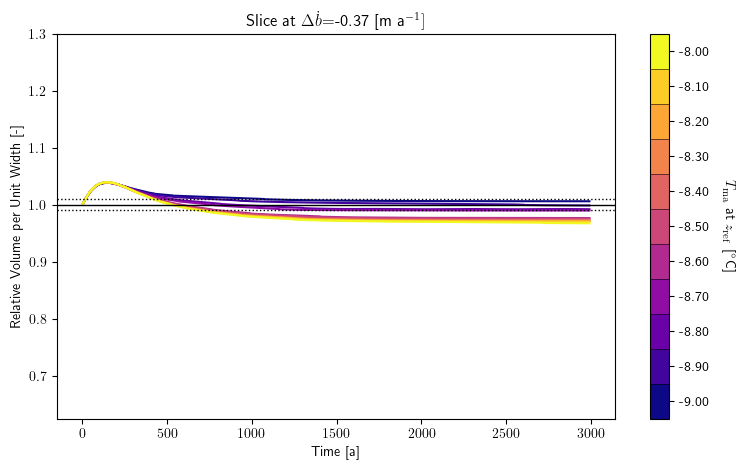

In [34]:
cmap, norm, s_map, bounds = make_colorbar(sub.T_ma)

fig, ax = plt.subplots(figsize=(9, 5))

for δT in sub.T_ma: 
    
    color = cmap(norm(δT))
    
    sub.sel(T_ma=δT, offset=-0.37).plot(x='t', ax=ax, c=color)

ax.axhline(0.99, ls=':', c='k', lw=1.0)
ax.axhline(1.01, ls=':', c='k', lw=1.0)
ax.axhline(1.00, ls='-', c='k', lw=1.0)


cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=np.linspace(sub.T_ma.min(),
                                  sub.T_ma.max(),
                                  sub.T_ma.size),
                ax=ax,
                boundaries=bounds,
                drawedges=True,
                format='%2.{}f'.format(2))

ax.set_title(r'Slice at $\Delta \dot{b}$=-0.37 [m a$^{-1}]$')
ax.set_ylabel('Relative Volume per Unit Width [-]')
ax.set_xlabel('Time [a]')
# annotate the colorbar axes
cbar.set_label('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]', rotation=270, labelpad=20)

ax.set_ylim(0.625, 1.30)


fig.savefig(f'./figs/{key}/{key}_Vprime_wrt_Tma_at_offset_-0.37.png', 
            dpi=600, bbox_inches='tight', 
            facecolor='w')

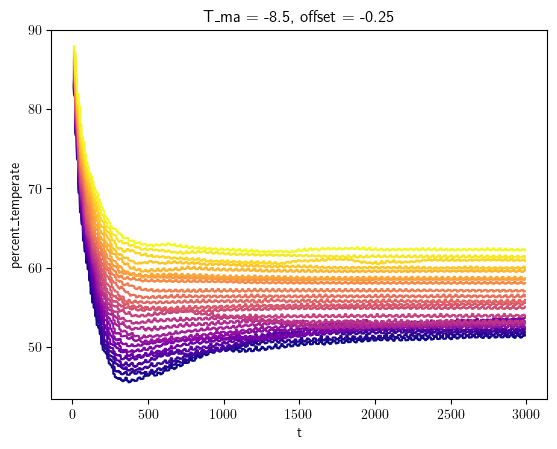

In [35]:
cmap, norm, s_map, bounds = make_colorbar(SS_2kya.offset)


fig, ax = plt.subplots()
for δb in SS_2kya.offset: 
    
    color = cmap(norm(δb))
    
    (SS_2kya['percent_temperate'].isel(t=slice(9,None)).rolling(t=10).mean()).sel(T_ma=-8.5, offset=δb).plot(x='t', ax=ax, c=color)
    
# ax.set_ylim(132, 135)
